In [1]:
%load_ext autoreload
%autoreload 2

# Visualization and Summary of Neural Network Experiments

In [2]:
import os

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

In [3]:
from lrann.experiments import get_latent_factors, retrieve_estimator
from lrann.datasets import DataLoader, random_train_test_split
from lrann.evaluations import precision_recall_score, mrr_score, auc_score
from lrann.model_collection import ModelCollection
from lrann.models import DeepNet
from lrann.estimators import ImplicitEst
from lrann.utils import is_cuda_available

## Load Config and Experiment Results

In [4]:
mf_best_mrr = yaml.load(open('experiment_config.yml'),
                        Loader=yaml.FullLoader)['mf_best_params']['mrr']
print("MRR for MF_best: {}".format(mf_best_mrr))

MRR for MF_best: 0.043602


In [5]:
folderpaths = dict.fromkeys(['concat', 'hadamard'])
filepaths = dict.fromkeys(['concat', 'hadamard'])

In [6]:
folderpaths['concat'] = 'results/nn_search/hadamard_FALSE_0420/'
folderpaths['hadamard'] = 'results/nn_search/hadamard_TRUE_0420/'

In [7]:
filenames = os.listdir(folderpaths['concat'])
filenames.remove('models')
filepaths['concat'] = [os.path.join(folderpaths['concat'], filename)
                       for filename in filenames]
filenames = os.listdir(folderpaths['hadamard'])
filenames.remove('models')
filepaths['hadamard'] = [os.path.join(folderpaths['hadamard'], filename)
                         for filename in filenames]

In [8]:
filepaths['concat']

['results/nn_search/hadamard_FALSE_0420/unpretrained_trainable_0.01.csv',
 'results/nn_search/hadamard_FALSE_0420/unpretrained_trainable_0.003.csv',
 'results/nn_search/hadamard_FALSE_0420/unpretrained_trainable_0.001.csv',
 'results/nn_search/hadamard_FALSE_0420/pretrained_untrainable_0.01.csv',
 'results/nn_search/hadamard_FALSE_0420/pretrained_untrainable_0.001.csv',
 'results/nn_search/hadamard_FALSE_0420/pretrained_untrainable_0.003.csv',
 'results/nn_search/hadamard_FALSE_0420/pretrained_trainable_0.01.csv',
 'results/nn_search/hadamard_FALSE_0420/pretrained_trainable_0.003.csv',
 'results/nn_search/hadamard_FALSE_0420/pretrained_trainable_0.001.csv']

In [9]:
filepaths['hadamard']

['results/nn_search/hadamard_TRUE_0420/pretrained_trainable_0.003_hadamard.csv',
 'results/nn_search/hadamard_TRUE_0420/pretrained_untrainable_0.01_hadamard.csv',
 'results/nn_search/hadamard_TRUE_0420/pretrained_trainable_0.01_hadamard.csv',
 'results/nn_search/hadamard_TRUE_0420/unpretrained_trainable_0.001_hadamard.csv',
 'results/nn_search/hadamard_TRUE_0420/pretrained_untrainable_0.003_hadamard.csv',
 'results/nn_search/hadamard_TRUE_0420/unpretrained_trainable_0.01_hadamard.csv',
 'results/nn_search/hadamard_TRUE_0420/pretrained_untrainable_0.001_hadamard.csv',
 'results/nn_search/hadamard_TRUE_0420/unpretrained_trainable_0.003_hadamard.csv',
 'results/nn_search/hadamard_TRUE_0420/pretrained_trainable_0.001_hadamard.csv']

In [10]:
results_concat = pd.concat([pd.read_csv(filepath)
                            for filepath in filepaths['concat']],
                           axis=0)
results_concat['rel_perf_gain'] = results_concat['test_mrr']/mf_best_mrr - 1
results_concat['rel_perf_gain'] = results_concat['rel_perf_gain']\
                                    .astype(float)\
                                    .map("{:.2%}".format)

In [11]:
results_hadamard = pd.concat([pd.read_csv(filepath)
                              for filepath in filepaths['hadamard']],
                             axis=0)
results_hadamard['rel_perf_gain'] = results_hadamard['test_mrr']/mf_best_mrr - 1
results_hadamard['rel_perf_gain'] = results_hadamard['rel_perf_gain']\
                                        .astype(float)\
                                        .map("{:.2%}".format)

## The best model (for `concat` and `hadamard`)

In [12]:
grouped = results_concat[['mode', 'test_mrr']].groupby('mode').max()
grouped.reset_index().sort_values('test_mrr', ascending=False)

,mode,test_mrr
1,pretrained_untrainable,0.044923
0,pretrained_trainable,0.044400
2,unpretrained_trainable,0.036911


In [13]:
grouped = results_hadamard[['mode', 'test_mrr']].groupby('mode').max()
grouped.reset_index().sort_values('test_mrr', ascending=False)

,mode,test_mrr
0,pretrained_trainable,0.047343
1,pretrained_untrainable,0.044922
2,unpretrained_trainable,0.044505


### Best Mode Results: `hadamard=False`

In [14]:
results_concat[results_concat['mode'] == 'pretrained_untrainable']\
    .sort_values('test_mrr', ascending=False).head(3)

,mode,model,torch_seed,learning_rate,epoch,test_mrr,eval_time,train_time,n_params,rel_perf_gain
1078,pretrained_untrainable,triple_model_relu,28,0.001,18,0.044923,20,2,343233,3.03%
187,pretrained_untrainable,single_model_elu,83,0.010,7,0.044828,27,3,334913,2.81%
207,pretrained_untrainable,single_model_relu,42,0.003,7,0.044598,10,1,334913,2.29%


In [15]:
results_concat[results_concat['mode'] == 'pretrained_trainable']\
    .sort_values('test_mrr', ascending=False).head(3)

,mode,model,torch_seed,learning_rate,epoch,test_mrr,eval_time,train_time,n_params,rel_perf_gain
537,pretrained_trainable,double_model_elu,147,0.001,17,0.044400,29,11,339073,1.83%
818,pretrained_trainable,double_model_tanh,42,0.001,18,0.044049,13,11,339073,1.02%
1126,pretrained_trainable,triple_model_sigmoid,147,0.003,6,0.043938,15,5,343233,0.77%


In [16]:
results_concat[results_concat['mode'] == 'unpretrained_trainable']\
    .sort_values('test_mrr', ascending=False).head(3)

,mode,model,torch_seed,learning_rate,epoch,test_mrr,eval_time,train_time,n_params,rel_perf_gain
794,unpretrained_trainable,double_model_sigmoid,83,0.001,14,0.036911,17,8,339073,-15.34%
1174,unpretrained_trainable,triple_model_sigmoid,28,0.001,14,0.036823,14,6,343233,-15.55%
754,unpretrained_trainable,double_model_sigmoid,17,0.001,14,0.036770,18,9,339073,-15.67%


### Best Mode Results: `hadamard=True`

In [17]:
results_hadamard[results_hadamard['mode'] == 'pretrained_untrainable']\
    .sort_values('test_mrr', ascending=False).head(3)

,mode,model,torch_seed,learning_rate,epoch,test_mrr,eval_time,train_time,n_params,rel_perf_gain
834,pretrained_untrainable,double_model_tanh,147,0.003,14,0.044922,9,1,332833,3.03%
496,pretrained_untrainable,single_model_tanh,83,0.010,16,0.044767,5,1,331777,2.67%
699,pretrained_untrainable,double_model_relu,83,0.010,19,0.044669,9,1,332833,2.45%


In [18]:
results_hadamard[results_hadamard['mode'] == 'pretrained_trainable']\
    .sort_values('test_mrr', ascending=False).head(3)

,mode,model,torch_seed,learning_rate,epoch,test_mrr,eval_time,train_time,n_params,rel_perf_gain
21,pretrained_trainable,perceptron,147,0.003,1,0.047343,3,3,330721,8.58%
960,pretrained_trainable,triple_model_elu,28,0.003,0,0.046758,18,3,333889,7.24%
220,pretrained_trainable,single_model_relu,147,0.003,0,0.046624,7,2,331777,6.93%


In [19]:
results_hadamard[results_hadamard['mode'] == 'unpretrained_trainable']\
    .sort_values('test_mrr', ascending=False).head(3)

,mode,model,torch_seed,learning_rate,epoch,test_mrr,eval_time,train_time,n_params,rel_perf_gain
9,unpretrained_trainable,perceptron,42,0.001,9,0.044505,2,3,330721,2.07%
10,unpretrained_trainable,perceptron,42,0.001,10,0.043655,3,3,330721,0.12%
11,unpretrained_trainable,perceptron,42,0.001,11,0.042566,3,3,330721,-2.38%


## Effectiveness: Accuracy Comparison

In [20]:
best_nn_model_no_hadamard = {}
for key in ['unpretrained_trainable', 'pretrained_trainable', 'pretrained_untrainable']:
    res = results_concat[results_concat['mode'] == key]\
        .sort_values('test_mrr', ascending=False)['test_mrr'].iloc[0]
    best_nn_model_no_hadamard[key] = res

In [21]:
best_nn_model_hadamard = {}
for key in ['unpretrained_trainable', 'pretrained_trainable', 'pretrained_untrainable']:
    res = results_hadamard[results_hadamard['mode'] == key]\
        .sort_values('test_mrr', ascending=False)['test_mrr'].iloc[0]
    best_nn_model_hadamard[key] = res

In [22]:
best_nn_model_no_hadamard

{'unpretrained_trainable': 0.03691129399670865,
 'pretrained_trainable': 0.04439957649469315,
 'pretrained_untrainable': 0.044923283007316135}

In [23]:
best_nn_model_hadamard

{'unpretrained_trainable': 0.044505381050330486,
 'pretrained_trainable': 0.04734281838327447,
 'pretrained_untrainable': 0.044921675682762605}

Remark: Red Threshold bar needs manual adjustment!

<function matplotlib.pyplot.show(*args, **kw)>

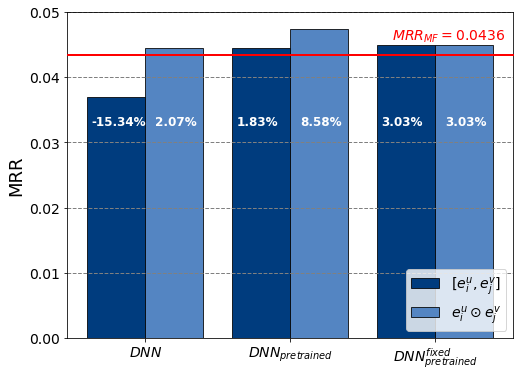

In [24]:
fig = plt.figure(figsize=(8,6))
plt.ylim([0, 0.05])
plt.bar(np.arange(3)-0.2, best_nn_model_no_hadamard.values(), width=0.4,
        edgecolor="black", lw=0.8, color='#003C7E',align='center')
plt.bar(np.arange(3)+0.2, best_nn_model_hadamard.values(), width=0.4,
        edgecolor="black", lw=0.8, color='#5485C2',align='center')
fig.patches.extend([plt.Rectangle([0.125, .78], 0.775, 0.002, fill=True,
                                  color='r', transform=fig.transFigure, figure=fig)])
plt.text(1.7, mf_best_mrr*1.05, "$MRR_{MF} = 0.0436$", fontdict={'fontsize':14, 'color': 'red'})
# put tags on best_no_hadamard
for idx, val in enumerate(["{:.2%}".format(val/mf_best_mrr-1)
                           for val in best_nn_model_no_hadamard.values()]):
    plt.text(-0.37+idx, mf_best_mrr*0.75, val,
             fontdict={'fontsize':12, 'color': 'white', 'weight': 'bold'})
for idx, val in enumerate(["{:.2%}".format(val/mf_best_mrr-1)
                           for val in best_nn_model_hadamard.values()]):
    plt.text(0.07+idx, mf_best_mrr*0.75, val,
             fontdict={'fontsize':12, 'color': 'white', 'weight': 'bold'})
plt.ylabel('MRR', fontdict={'fontsize': 18})
plt.xticks(range(3), [r"$DNN$",
                      r"$DNN_{pretrained}$",
                      r"$DNN_{pretrained}^{fixed}$"],
           fontsize=14)
plt.yticks(fontsize=14)
plt.legend([r'$[e_i^u, e_j^v]$', r'$e_i^u \odot e_j^v$'], loc='lower right', prop={'size': 14})
plt.grid(color='gray', linestyle='--', linewidth=1, axis='y', which='both')
# plt.grid(True)
plt.show

## Compute AUC and MAP@10 for best model configurations using `experiments.retrieve_model`

#### Best Model Configurations

In [25]:
mapper = {'unpretrained_trainable': 'DNN',
          'pretrained_trainable': 'DNN_pretrained',
          'pretrained_untrainable': 'DNN_pretrained_fixed'}
reverse_mapper = dict(zip(mapper.values(), mapper.keys()))

In [26]:
best_model_configs = dict().fromkeys(['concat', 'hadamard'])

In [27]:
best_model_configs['concat'] = dict.fromkeys(mapper.values())
best_model_configs['hadamard'] = dict.fromkeys(mapper.values())

In [28]:
for key in ['unpretrained_trainable', 'pretrained_trainable', 'pretrained_untrainable']:
    checkpoint = results_concat[results_concat['mode'] == key]
    checkpoint = checkpoint.sort_values('test_mrr', ascending=False).iloc[0]
    best_model_configs['concat'][mapper[key]] = \
        checkpoint[['mode', 'model', 'torch_seed', 'learning_rate', 'epoch']].to_dict()

In [29]:
for key in ['unpretrained_trainable', 'pretrained_trainable', 'pretrained_untrainable']:
    checkpoint = results_hadamard[results_hadamard['mode'] == key]
    checkpoint = checkpoint.sort_values('test_mrr', ascending=False).iloc[0]
    best_model_configs['hadamard'][mapper[key]] = \
        checkpoint[['mode', 'model', 'torch_seed', 'learning_rate', 'epoch']].to_dict()

In [30]:
best_model_configs['concat']

{'DNN': {'mode': 'unpretrained_trainable',
  'model': 'double_model_sigmoid',
  'torch_seed': 83,
  'learning_rate': 0.001,
  'epoch': 14},
 'DNN_pretrained': {'mode': 'pretrained_trainable',
  'model': 'double_model_elu',
  'torch_seed': 147,
  'learning_rate': 0.001,
  'epoch': 17},
 'DNN_pretrained_fixed': {'mode': 'pretrained_untrainable',
  'model': 'triple_model_relu',
  'torch_seed': 28,
  'learning_rate': 0.001,
  'epoch': 18}}

In [31]:
best_model_configs['hadamard']

{'DNN': {'mode': 'unpretrained_trainable',
  'model': 'perceptron',
  'torch_seed': 42,
  'learning_rate': 0.001,
  'epoch': 9},
 'DNN_pretrained': {'mode': 'pretrained_trainable',
  'model': 'perceptron',
  'torch_seed': 147,
  'learning_rate': 0.003,
  'epoch': 1},
 'DNN_pretrained_fixed': {'mode': 'pretrained_untrainable',
  'model': 'double_model_tanh',
  'torch_seed': 147,
  'learning_rate': 0.003,
  'epoch': 14}}

## Retrieve Best Models and compute `MAP@10` as well as `AUC`-Score

In [53]:
k = 10

In [54]:
model_filepaths = dict.fromkeys(['concat', 'hadamard'])
model_filepaths['concat'] = 'results/nn_search/hadamard_FALSE_0420/models'
model_filepaths['hadamard'] = 'results/nn_search/hadamard_TRUE_0420/models'

In [55]:
best_model_filepath = dict().fromkeys(['concat', 'hadamard'])
best_model_filepath['concat'] = dict.fromkeys(mapper.values())
best_model_filepath['hadamard'] = dict.fromkeys(mapper.values())

In [56]:
for input_type in ['concat', 'hadamard']:
    for mode in mapper.values():
        model_config = best_model_configs[input_type][mode]
        for filename in os.listdir(model_filepaths[input_type]):
            if ('_'+model_config['mode']+'_' in filename)&(str(model_config['learning_rate']) in filename):
                best_model_filepath[input_type][mode] = os.path.join(model_filepaths[input_type],
                                                                     filename)

In [57]:
best_model_filepath

{'concat': {'DNN': 'results/nn_search/hadamard_FALSE_0420/models/best_dnn_model_unpretrained_trainable_0.001_False.pth',
  'DNN_pretrained': 'results/nn_search/hadamard_FALSE_0420/models/best_dnn_model_pretrained_trainable_0.001_False.pth',
  'DNN_pretrained_fixed': 'results/nn_search/hadamard_FALSE_0420/models/best_dnn_model_pretrained_untrainable_0.001_False.pth'},
 'hadamard': {'DNN': 'results/nn_search/hadamard_TRUE_0420/models/best_dnn_model_unpretrained_trainable_0.001_True.pth',
  'DNN_pretrained': 'results/nn_search/hadamard_TRUE_0420/models/best_dnn_model_pretrained_trainable_0.003_True.pth',
  'DNN_pretrained_fixed': 'results/nn_search/hadamard_TRUE_0420/models/best_dnn_model_pretrained_untrainable_0.003_True.pth'}}

### Retrieve Data for additional score computation

In [58]:
config = yaml.load(open('experiment_config.yml'), Loader=yaml.FullLoader)

In [59]:
data = DataLoader().load_movielens('100k')
data.implicit_(use_user_mean=True)
rd_split_state = np.random.RandomState(seed=config['train_test_split_seed'])
train_data, test_data = random_train_test_split(data,
                                                test_percentage=config['test_percentage'],
                                                random_state=rd_split_state)

In [60]:
best_nn_model_no_hadamard_map = dict.fromkeys(best_model_configs['concat'].keys())
best_nn_model_hadamard_map = dict.fromkeys(best_model_configs['hadamard'].keys())

In [61]:
best_nn_model_no_hadamard_auc = dict.fromkeys(best_model_configs['concat'].keys())
best_nn_model_hadamard_auc = dict.fromkeys(best_model_configs['hadamard'].keys())

### Now as we know the best model configs and the best model parameter filepaths, we can retrieve our models and compute the respective scores

### `concat`

In [81]:
use_hadamard = False

In [82]:
for mode in best_nn_model_no_hadamard_map.keys():
    dnn_est = retrieve_estimator(data,
                                 use_hadamard=use_hadamard,
                                 embedding_dim=config['embedding_dim'],
                                 model_name=best_model_configs['concat'][mode]['model'],
                                 model_parameters_filepath=best_model_filepath['concat'][mode])
    print("Mode: {} --- Hadamard: {} --- MRR: {:.4f}".format(mode,
                                                             use_hadamard,
                                                             mrr_score(dnn_est, test_data).mean()))
    best_nn_model_no_hadamard_map[mode] = precision_recall_score(dnn_est, test_data, k=k)[0].mean()
    best_nn_model_no_hadamard_auc[mode] = auc_score(dnn_est, test_data,
                                                    auc_selection_seed=config['auc_selection_seed']).mean()

Mode: DNN --- Hadamard: False --- MRR: 0.0369
Mode: DNN_pretrained --- Hadamard: False --- MRR: 0.0444
Mode: DNN_pretrained_fixed --- Hadamard: False --- MRR: 0.0449


### `hadamard`

In [83]:
use_hadamard = True

In [84]:
for mode in best_nn_model_no_hadamard_map.keys():
    dnn_est = retrieve_estimator(data,
                                 use_hadamard=use_hadamard,
                                 embedding_dim=config['embedding_dim'],
                                 model_name=best_model_configs['hadamard'][mode]['model'],
                                 model_parameters_filepath=best_model_filepath['hadamard'][mode])
    print("Mode: {} --- Hadamard: {} --- MRR: {:.4f}".format(mode,
                                                             use_hadamard,
                                                             mrr_score(dnn_est, test_data).mean()))
    best_nn_model_hadamard_map[mode] = precision_recall_score(dnn_est, test_data, k=k)[0].mean()
    best_nn_model_hadamard_auc[mode] = auc_score(dnn_est, test_data,
                                                 auc_selection_seed=config['auc_selection_seed']).mean()

Mode: DNN --- Hadamard: True --- MRR: 0.0445
Mode: DNN_pretrained --- Hadamard: True --- MRR: 0.0473
Mode: DNN_pretrained_fixed --- Hadamard: True --- MRR: 0.0449


### Results

In [85]:
best_nn_model_no_hadamard_map

{'DNN': 0.06275167785234899,
 'DNN_pretrained': 0.0738255033557047,
 'DNN_pretrained_fixed': 0.07063758389261746}

In [86]:
best_nn_model_hadamard_map

{'DNN': 0.07164429530201342,
 'DNN_pretrained': 0.07533557046979866,
 'DNN_pretrained_fixed': 0.07130872483221476}

In [87]:
best_nn_model_no_hadamard_auc

{'DNN': 0.892029462000453,
 'DNN_pretrained': 0.9195430902198752,
 'DNN_pretrained_fixed': 0.9138041976615925}

In [88]:
best_nn_model_hadamard_auc

{'DNN': 0.915676321422413,
 'DNN_pretrained': 0.9240985119097695,
 'DNN_pretrained_fixed': 0.9216450226686062}